# Will Do Customers Stop Doing Business With the Bank?

> This study aims to concisely describe a banking dataset was used to generate meaningful insights by exploring and clustering data through visualization, statistical analysis, and principal component analysis to develop a well-rounded classification model that can make an accurate prediction whether a bank’s customers will churn or not.

What is Customer Churn in Banking? 

“When a client ends their relationship with us by switching to another bank.”

![](http://)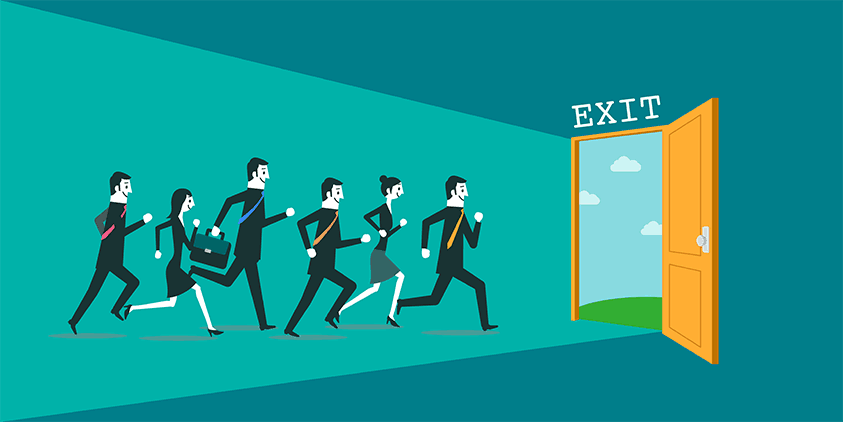                    

# Introduction

### Scope

> The aim is to predict whether the bank's customers leave the bank or not. 

### Data Definition

****RowNumber**** — represent to the row number. This column will be removed.

**CustomerID** — contains random and unique values. This column will be removed.

**Surname** — the surname of a customer has no impact on their decision to leave the bank. This column will be removed.

**CreditScore** — it is a score which shows the customer's credit behaviors. We will keep this column.

**Geography** — a customer’s location can affect their decision to leave the bank. We will keep this column.

**Gender** — it could be interesting to explore whether gender plays a role in a customer leaving the bank. 

**Age** — Age of the customer.

**Tenure** — refers to the number of years that the customer has been a client of the bank. 

**Balance** — Balance of the customers.

**NumOfProducts** — the number of products that a customer has purchased through the bank.

**HasCrCard** — indicates whether or not a customer has a credit card. (0=No,1=Yes)

**IsActiveMember** —  indicates whether or not a customer is active or not. (0=No,1=Yes)

**EstimatedSalary** — customer salary can has impact on their decision to leave the bank that's why we will keep it.

**Exited** — whether or not the customer left the bank. This is what we have to predict. (0=No,1=Yes)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold


from sklearn.metrics import roc_curve 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Import Data

In [ ]:
df = pd.read_csv("../input/predicting-churn-for-bank-customers/Churn_Modelling.csv")

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
# Check columns list and missing values
df.isnull().sum()

In [ ]:
# Get unique count for each variable
df.nunique()

> Let's remove the features which has no impact on churn of the customers.

In [ ]:
drop_list = [
'RowNumber',
'CustomerId',
'Surname'
]


df=df.drop(drop_list,axis=1)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df["Exited"].replace(to_replace="C", value=1, inplace=True)
df["Exited"].replace(to_replace="N", value=0, inplace=True)

In [ ]:
df.info()

# EDA

In [ ]:
df["Exited"].value_counts()

In [ ]:
labels = 'Churn', 'Not Churn'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Distribution of Customers Churn and Not Churn", size = 8)
plt.show()

>  It seems that there is no balance between churn and not churn customers in the dataset. When we are developing a model, we have to take into consideration this situation.

### Numerical Features

In [ ]:
# Correlation Matrix for Numerical Features
f, ax = plt.subplots(figsize= [10,8])
g = sns.heatmap(df[["CreditScore","Age","Tenure","NumOfProducts","HasCrCard","Balance", "EstimatedSalary", "Exited"]].corr(),annot=True, fmt = ".2f", ax=ax, cmap = "magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

> It seems that there is no correlation between numerical features.

#### Age

In [ ]:
g = sns.FacetGrid(df, col='Exited')
g = g.map(sns.distplot, "Age", color="m")

#### Balance

In [ ]:
g = sns.FacetGrid(df, col='Exited')
g = g.map(sns.distplot, "Balance", color="c")

### Cathegorical Features

### Geography

In [ ]:
g = sns.catplot(x="Geography",y="Exited", data=df, kind="bar", height = 5 ,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Churn Probability")

### Gender

In [ ]:
g = sns.barplot(x="Gender",y="Exited",data=df)
g = g.set_ylabel("Churn Probability")

### Missing Values

In [ ]:
df.isnull().sum()

> There is no missing value in the dataset. 

### Outlier Detection

In [ ]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, Balance, Duration
Outliers_to_drop = detect_outliers(df,2,["CreditScore","Age","Tenure", "Balance", "NumOfProducts", "EstimatedSalary"])

We applied Tukey Method to remove outliers from dataset. Let's remove them!

In [ ]:
# Drop outliers
df = df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### Convert Data Format

> Let's convert long format to wide format.

In [ ]:
df = pd.get_dummies(df)

df.head()

In [ ]:
# Correlation Matrix for Wide Format Data
f, ax = plt.subplots(figsize= [12,10])
g = sns.heatmap(df.corr(),annot=True, fmt = ".2f", ax=ax, cmap = "magma")
ax.set_title("Correlation Matrix", fontsize=25)
plt.show()

In [ ]:
y = df["Exited"]

X = df.drop(labels = ["Exited"],axis = 1)

# Model

In [ ]:
# Splitting data into testing and training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1992)

### Oversampling

> In EDA part we noted that data is imbalance. 

> Let's apply SMOTE oversampling method to avoid overfitting.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy=1)
X_train_smo, y_train_smo = smote.fit_sample(X_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
y_train_smo.value_counts()

### Cross Validation

In [ ]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=5)

In [ ]:
# Modeling step Test differents algorithms 
random_state = 1992
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(RandomForestClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(SVC())
classifiers.append(XGBClassifier())


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train_smo, y = y_train_smo, scoring = "f1", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogisticRegression","RandomForest","KNeighboors","SVC","XGB"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean F1 Score")
g = g.set_title("Cross validation scores")

### Hyperparameter Tunning

> Let's perform a grid search optimization for each classifier.

#### Logistic Regression

In [ ]:
# LogisticRegression

LR = LogisticRegression()

param_grid = {
                  "C":np.logspace(-3,3,7), 
                  "penalty":["l1","l2"]
}

gs_LR = GridSearchCV(LR, param_grid = param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gs_LR.fit(X_train_smo,y_train_smo)


In [ ]:
y_pred = gs_LR.predict(X_test)

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))

#### Random Forest

In [ ]:
# RandomForest 

RFC = RandomForestClassifier()


param_grid = {
              "max_depth": [4,5,7],
              "max_features": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[80,100,120],
              "criterion": ["gini"]
}


gs_RFC = GridSearchCV(RFC,param_grid = param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gs_RFC.fit(X_train_smo,y_train_smo)


In [ ]:
y_pred = gs_RFC.predict(X_test)

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))

#### KNeighboors

In [ ]:
# KNeighbors

KNN = KNeighborsClassifier()

k_grid={
        'n_neighbors':np.arange(2,20)
}

gs_KNN=GridSearchCV(KNN, k_grid, cv=kfold, refit=True, n_jobs=4)

gs_KNN.fit(X_train_smo,y_train_smo)

In [ ]:
y_pred = gs_KNN.predict(X_test)

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))

#### SVC

In [ ]:
# SVC
SVM = SVC()


param_grid = {
                'C': [0.1, 1, 10], 
                'gamma': [0.01, 0.1, 1],
                'kernel': ['rbf']
}

gs_SVM = GridSearchCV(SVM, param_grid, cv=kfold, n_jobs=4)

gs_SVM.fit(X_train_smo,y_train_smo)

In [ ]:
y_pred = gs_SVM.predict(X_test)

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))

#### XGB

In [ ]:
# XGB

XGB = XGBClassifier()

param_grid = {
                'n_estimators': [50,80,100,120], 
                'gamma': [0.01,0.001,0.001], 
                'max_depth': [5,6,7,8],
                'min_child_weight': [1,5,8,10], 
                'learning_rate': [0.05,0.1,0.2]
}

gs_XGB = GridSearchCV(estimator = XGB, param_grid =  param_grid,  cv=kfold, n_jobs=4)

gs_XGB.fit(X_train_smo,y_train_smo)

In [ ]:
y_pred = gs_XGB.predict(X_test)

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))

Let's look into a voting classifier to combine the predictions coming from the best 3 classifiers

In [ ]:
# Ensemble Modeling
voting_clas = VotingClassifier(estimators=[('XGB', gs_XGB.best_estimator_),('extc', gs_LR.best_estimator_),('ada',gs_RFC.best_estimator_)], voting='soft', n_jobs=4)

voting_clas = voting_clas.fit(X_train_smo, y_train_smo)

In [ ]:
y_pred = voting_clas.predict(X_test)

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))

It seems that ensemble model gives best scores. 